In [ ]:
#https://www.kaggle.com/code/mahsazamanifard/fashion-mnist-dataset-hp-tuning-using-keras-tuner

# Summary:
So this is originally a project on Coursera's project network, I tried it but due to some reasons unknown to me! what the instructor was doing, would not work for me and returned an error although I was doing exactly what he was, line by line!

So after some research, I adjusted a few things and came up with this code, and it works!

[Here's a link to the project](https://coursera.org/share/fb4ab114deb358774093b9d80843ae13) if you want to check it out or some other projects!

# Library and Data Import:

In [1]:
import tensorflow as tf
import keras_tuner
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

In [2]:
( x_train, y_train) , ( x_test, y_test)=tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
y_train.shape 

(60000,)

In [5]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

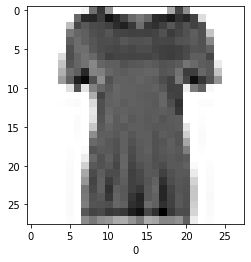

In [6]:
plt.imshow(x_train[10],cmap='binary')
plt.xlabel(y_train[10])
plt.show()

# Creating a Function to Create the Model:

In [7]:
#create a function which will create the model we want to train
def create_model(hp): #hp is a hyperparameter obj, we need it for keras tuner
    num_hidden_layers=1
    num_units=8
    dropout_rate=.1
    learning_rate=0.01
    if hp:
        num_hidden_layers=hp.Choice('num_hidden_layers',values=[1,2,3])
        num_units=hp.Choice('num_units',values=[8,16,32])
        dropout_rate=hp.Float('dropout_rate',min_value=0.1, max_value=0.5,step=.1) #floating point value between 2 values
        learning_rate=hp.Choice('learning_rate',values=[0.01,0.03,0.1,0.3])
        
    model= tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
    model.add(tf.keras.layers.Lambda (lambda x: x/255.)) # the pixel values in the pics are from 0 to 255 so this normalizes the input
    
    for _ in range(0, num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_units,activation='relu'))
        model.add(tf.keras.layers.Dropout(dropout_rate))
    
    model.add(tf.keras.layers.Dense(10,activation='softmax'))
    
    model.compile(
      loss='sparse_categorical_crossentropy', #sparse because the target is not one-hot-encoded
      optimizer=tf.keras.optimizers.Adam (learning_rate=learning_rate),
      metrics=["accuracy"])
    
    return model

In [8]:
create_model(None).summary()

2022-04-18 16:16:53.385242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 16:16:53.504280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 16:16:53.505266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
lambda (Lambda)              (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 6280      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                90        
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


2022-04-18 16:16:53.507301: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-18 16:16:53.507656: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 16:16:53.508632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 16:16:53.510082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [9]:
#1-if we are tuning all the hyperparamenters defined
#then we won't need a costum tuner class, we can use any tuner. but we want to
#do sth. in addition to what we wrote in create model func: find out optimal batch size
#in order to do that we need to create a customtuner
#2-we have random search and hyper band tuners as well to use instead of bayesianoptimization

class CustomTuner(keras_tuner.tuners.BayesianOptimization):
  #run_trial function executes at the start of each trial
  # it's essentialy an experiment with the hyper parameter values
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size']=trial.hyperparameters.Int('batch_size',32,128,step=32)
        return super(CustomTuner,self).run_trial(trial,*args,**kwargs)

In [10]:
#higher max_trials take a bit of time to complete, to speed things up, I'm setting it to 7
tuner=CustomTuner(create_model,
                  objective="val_accuracy",
                  max_trials=7,
                  directory='logs',
                  project_name='fashion_mnist', 
                  overwrite=True)

In [11]:
#since batch size is not originally in the create model func, it's not shown in the summary
tuner.search_space_summary() 

Search space summary
Default search space size: 4
num_hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
num_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.03, 0.1, 0.3], 'ordered': True}


# Searching for the best parameters and Choosing The Best Model:

In [12]:
tuner.search(x_train,y_train, validation_data=(x_test,y_test),epochs=5,verbose=True)

Trial 7 Complete [00h 00m 07s]
val_accuracy: 0.10000000149011612

Best val_accuracy So Far: 0.8504999876022339
Total elapsed time: 00h 01m 32s


In [13]:
tuner.results_summary()

Results summary
Results in logs/fashion_mnist
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_hidden_layers: 1
num_units: 32
dropout_rate: 0.1
learning_rate: 0.01
batch_size: 128
Score: 0.8504999876022339
Trial summary
Hyperparameters:
num_hidden_layers: 3
num_units: 32
dropout_rate: 0.1
learning_rate: 0.01
batch_size: 128
Score: 0.8460000157356262
Trial summary
Hyperparameters:
num_hidden_layers: 3
num_units: 32
dropout_rate: 0.5
learning_rate: 0.01
batch_size: 128
Score: 0.5781000256538391
Trial summary
Hyperparameters:
num_hidden_layers: 3
num_units: 8
dropout_rate: 0.30000000000000004
learning_rate: 0.01
batch_size: 96
Score: 0.4738999903202057
Trial summary
Hyperparameters:
num_hidden_layers: 3
num_units: 32
dropout_rate: 0.5
learning_rate: 0.01
batch_size: 32
Score: 0.37720000743865967
Trial summary
Hyperparameters:
num_hidden_layers: 1
num_units: 8
dropout_rate: 0.1
learning_rate: 0.3
batch_size: 32
Score: 0.1000000014901

In [14]:
model=tuner.get_best_models()[0]
model.summary()
#Note the batch size is not shown here and should find it in the first item in the above list

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
lambda (Lambda)              (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [15]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=2,
    min_delta=0.001,
    restore_best_weights=True,
    monitor='val_accuracy'
)

# Training the Model Further With The Chosen Parametes:

In [16]:
history=model.fit(x_train,y_train,
            validation_data=(x_test,y_test),
            epochs=40,batch_size=128,
            callbacks=[early_stopping])

Epoch 1/40
469/469 [==============================] - 1s 2ms/step - loss: 0.4435 - accuracy: 0.8358 - val_loss: 0.4421 - val_accuracy: 0.8408
Epoch 2/40
469/469 [==============================] - 1s 2ms/step - loss: 0.4380 - accuracy: 0.8384 - val_loss: 0.4281 - val_accuracy: 0.8463
Epoch 3/40
469/469 [==============================] - 1s 3ms/step - loss: 0.4356 - accuracy: 0.8409 - val_loss: 0.4379 - val_accuracy: 0.8447
Epoch 4/40
469/469 [==============================] - 1s 2ms/step - loss: 0.4310 - accuracy: 0.8415 - val_loss: 0.4370 - val_accuracy: 0.8465


# Final Result:

In [17]:
model.evaluate(x_test, y_test)[1]

313/313 [==============================] - 1s 2ms/step - loss: 0.4281 - accuracy: 0.8463


0.8463000059127808